**1. Import all neccessery libraries**

In [1]:
from google.cloud import bigquery
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import time
import requests
import json
import calendar

**2. Get data**

    2.1 From GoogleCloud and create a Data Frame 'df_query'

NOTE:

    'new_crypto_ethereum_sample20k_new_wallets_2023' was previously created with SQL-queries on BigQuery.
    All queries are saved in query_ethereum_project.txt

key_file_path = "my-project-444222-1be5aecf7dbb.json"

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = key_file_path

In [3]:
client = bigquery.Client()

query = """
SELECT *
FROM `my-project-444222.wallets_2023.new_crypto_ethereum_sample20k_new_wallets_2023`
"""
df_query = client.query(query).to_dataframe()

In [4]:
df_query.head(5)

,from_address,first_transaction_time,to_address,gas,gas_price,hash,transaction_type,receipt_gas_used,value
0,0x560d6afd57691c9d73728214d7287f7ba495bfb1,2023-04-13 02:17:59+00:00,0xf48b45479ba7e121a3542626d5a5f3b07ec5b65d,197376,40731401487,0x5deb9d2adf75d687cfc95895f5fdda0c0d6ccbb37620...,2,131584,500000000000000000.000000000
1,0x67c35bea48140d64922aac45fab68f5f7ab30263,2023-09-12 14:03:23+00:00,0x3a23f943181408eac424116af7b7790c94cb97a5,67840,26186170128,0x1e4fd147875750578c15608b56775fc31add5cf16cf8...,2,67786,5300000000000000.000000000
2,0xb05490b8e0a65f14ef11245094fa847217999df9,2023-07-15 10:14:11+00:00,0x92853a460a0f25fcbea51c02c4ae167cc0a5ccc4,137216,12625542978,0x5d6ad02f3f6444089cf9750c962f18f0b53a5aa9673a...,2,133313,0E-9
3,0x8b613b54725d4ac4dd29876d7d1e7ac19079aa60,2023-08-17 10:22:59+00:00,0xb2089a7069861c8d90c8da3aacab8e9188c0c531,77568,15535760611,0x184f06f7f119660590cc52389f28b6dab98f179eb1cd...,2,51712,0E-9
4,0x740325f3ad2f2eb22ac46f70b5614ada96a0d574,2023-02-15 09:53:47+00:00,0x95ad61b0a150d79219dcf64e1e6cc01f0b64c4ce,77824,24192656923,0xc139b7ff06211765c560e03e7556eb8cd308dbc2d116...,2,51883,0E-9


In [42]:
df_query.to_csv('bigquery_ethereum_sample20k.csv')

    2.2 With api.etherscan and create Data Frame 'df_api'.
    
    When 'from_address' is known, it is possible to get all informations about address
    with api.etherscan.

In [5]:
etherscan_api_key = "MY_API_KEY"

address = df_query['from_address'].tolist()

In [6]:
def get_api_json(addresses):
    """
    Fetch the first transaction for a list of Ethereum addresses using the Etherscan API.

    This function iterates over a list of Ethereum addresses, sends API requests to fetch 
    their transaction history, and saves only the first transaction (by timestamp) for each 
    address into a CSV file. If an address has no transactions, it logs this information 
    into the CSV file. If an API request fails, the error is logged in a separate log file.

    Args:
        addresses (list): A list of Ethereum addresses as strings.

    Returns:
        None: The function writes data to a CSV file and logs errors if any.

    Notes:
        - Only the first transaction (sorted by `timeStamp`) for each address is saved in 
          '20k_first_transactions.csv'.
        - If an address has no transactions, a row with `{'address': address, 'transactions': 0}` 
          is added to the CSV.
        - Failed responses are logged in 'api_errors.log'.
        - Ensure that the API key (`etherscan_api_key`) is correctly configured.

    Raises:
        None: The function handles errors by logging them to 'api_errors.log'.
    """
    for address in addresses:
        response = requests.get(
            f"https://api.etherscan.io/api?module=account&action=txlist"
            f"&address={address}&startblock=0&endblock=99999999&sort=asc"
            f"&apikey={etherscan_api_key}"
        ) 
        if response.status_code == 200 and response.json()['status'] == '1':
            transactions = response.json()['result']
            if transactions:
                first_transaction = transactions[0]
                transactions_df = pd.DataFrame([first_transaction])
                transactions_df.to_csv(
                    '20k_first_transactions.csv',
                    mode='a',
                    header=not os.path.exists('got_from_api_first_transactions.csv'),
                    index=False
                )
            else:
                pd.DataFrame(
                    [{'address': address, 'transactions': 0}]
                ).to_csv(
                    'got_from_api_first_transactions.csv',
                    mode='a',
                    header=False,
                    index=False
                )
        else:
            with open('api_errors.log', 'a') as log_file:
                log_file.write(
                    f"Failed response for address: {address}, "
                    f"status: {response.json().get('status')}\n"
                )


In [7]:
def rate_limited_function(func, *args):
    """
    Wrap a function to limit the number of calls to comply with API rate limits.

    This decorator ensures that the decorated function respects a limit of 
    five calls per second by adding a delay when the limit is reached.

    Args:
        func (callable): The function to be rate-limited. It should accept 
        arguments passed by the caller of the wrapped function.

    Returns:
        callable: A wrapped version of the input function that enforces 
        the rate limit.

    Notes:
        - The delay is introduced using `time.sleep()` when the number of 
          calls reaches the limit within a one-second window.
        - This implementation uses a nonlocal counter (`request_count`) 
          and a timestamp (`start_time`) to track the number of calls and 
          elapsed time.

    Example:
        ```
        def fetch_data(param):
            # Your function logic here
            pass
        
        rate_limited_fetch_data = rate_limited_function(fetch_data)
        rate_limited_fetch_data(arg1, arg2)
        ```
    """
    request_count = 0
    start_time = time.time()

    def wrapper(*args):
        nonlocal request_count, start_time
        
        result = func(*args)
        
        request_count =+ 1
        if request_count == 5:
            elapsed_time = time.time() - start_time
            if elapsed_time < 1:
                time.sleep(1 - elapsed_time)
            request_count = 0
            start_time = time.time()
            
        return result 

    return wrapper

In [49]:
rate_limited_get_api_json = rate_limited_function(get_api_json)
rate_limited_get_api_json(address)

In [35]:
df_api = pd.read_csv('got_from_api_first_transactions.csv') 

In [36]:
df_api.head(5)

,blockNumber,blockHash,timeStamp,hash,nonce,transactionIndex,from,to,value,gas,gasPrice,input,methodId,functionName,contractAddress,cumulativeGasUsed,txreceipt_status,gasUsed,confirmations,isError
0,17035845,0xf84c428f5ed89e29757242486b2957da4b6a3c3a6e3f...,1681352279,0x5deb9d2adf75d687cfc95895f5fdda0c0d6ccbb37620...,0,48,0x560d6afd57691c9d73728214d7287f7ba495bfb1,0xf48b45479ba7e121a3542626d5a5f3b07ec5b65d,500000000000000000,197376,40731401487,0xba41b0c6000000000000000000000000000000000000...,0xba41b0c6,"mint(uint256 inAmount, bytes32[] merkleProof)",NaN,4277588,1.0,131584,4439701,0
1,18120578,1694525675,0x4a44edd542126d316e77818d57efee097dd123125f4e...,4,0xd28e9014af3ec057d1832d6ebec077adcb2341e9c0ed...,157,0x862d5e6bd23948062f6db450015a33c1f2594a6b,0x67c35bea48140d64922aac45fab68f5f7ab30263,18140823025860190,21000,23034940343,0,1,0x,NaN,13638466,21000.0,3354969,0x,NaN
2,17693093,0xb812f2de16131b2b7beb907f2f3b7a990d5b889bf9ad...,1689354659,0x5bba8aeb4621b62ebfbb2cc986a40fe7b540d8240668...,1188513,32,0xa7efae728d2936e78bda97dc267687568dd593f3,0xb05490b8e0a65f14ef11245094fa847217999df9,33714000000000000,210000,49339994961,0x,0x,NaN,NaN,4077094,1.0,21000,3782455,0
3,17931606,0x2c6e5b3bbb544cdb9c5e3ee292ecffabd2911c918b07...,1692239831,0xa7650fb970a3c640f95011922486ee8ac8ce86ad534e...,64,120,0xc661a914110a7b9c745e0da352bf79627f88efbe,0x8b613b54725d4ac4dd29876d7d1e7ac19079aa60,1500000000000000,21000,22378654725,0x,0x,NaN,NaN,12520353,1.0,21000,3543942,0
4,16633362,0x8eed2605e1168c11224468667ed1cb7378a241992cc1...,1676454659,0x4943ce8316acc275cd1105a86dcf90dc581b810a28c6...,190852,21,0x8d56f551b44a6da6072a9608d63d664ce67681a5,0x740325f3ad2f2eb22ac46f70b5614ada96a0d574,8666620000000000,50000,27468989502,0x,0x,NaN,NaN,1064344,1.0,21000,4842186,0




It's interesting to understand the difference between the tables. The 'address' list was selected from BigQuery, and the table 'new_crypto_ethereum_sample20k_new_wallets_2023' contains the first outgoing transactions of new wallets (address), meaning the from_address.

Meanwhile, the table obtained through API filtering for 'address' includes the first transactions where the 'address' is in the 'to' field, meaning these are their incoming transactions.



**Because the API returned JSON with varying key sequences, some data was unpacked incorrectly into the table. Let's fix this:**

In [37]:
def fix_row(row):
    """
    Fixes row values based on the length of the 'timeStamp' column.
    If 'timeStamp' length is greater than 10, reassign the values as per the given logic.
    """
    if len(str(row['timeStamp'])) > 10:
        temp_blockHash = row['blockHash']
        temp_nonce = row['nonce']
        temp_hash = row['hash']
        temp_timestamp = row['timeStamp']

        row['blockHash'] = temp_nonce
        row['timeStamp'] = temp_blockHash
        row['hash'] = temp_timestamp
        row['nonce'] = temp_hash
    return row

In [38]:
df_api = df_api.apply(fix_row, axis=1)

In [39]:
df_api.head(5)

,blockNumber,blockHash,timeStamp,hash,nonce,transactionIndex,from,to,value,gas,gasPrice,input,methodId,functionName,contractAddress,cumulativeGasUsed,txreceipt_status,gasUsed,confirmations,isError
0,17035845,0xf84c428f5ed89e29757242486b2957da4b6a3c3a6e3f...,1681352279,0x5deb9d2adf75d687cfc95895f5fdda0c0d6ccbb37620...,0,48,0x560d6afd57691c9d73728214d7287f7ba495bfb1,0xf48b45479ba7e121a3542626d5a5f3b07ec5b65d,500000000000000000,197376,40731401487,0xba41b0c6000000000000000000000000000000000000...,0xba41b0c6,"mint(uint256 inAmount, bytes32[] merkleProof)",NaN,4277588,1.0,131584,4439701,0
1,18120578,0xd28e9014af3ec057d1832d6ebec077adcb2341e9c0ed...,1694525675,0x4a44edd542126d316e77818d57efee097dd123125f4e...,4,157,0x862d5e6bd23948062f6db450015a33c1f2594a6b,0x67c35bea48140d64922aac45fab68f5f7ab30263,18140823025860190,21000,23034940343,0,1,0x,NaN,13638466,21000.0,3354969,0x,NaN
2,17693093,0xb812f2de16131b2b7beb907f2f3b7a990d5b889bf9ad...,1689354659,0x5bba8aeb4621b62ebfbb2cc986a40fe7b540d8240668...,1188513,32,0xa7efae728d2936e78bda97dc267687568dd593f3,0xb05490b8e0a65f14ef11245094fa847217999df9,33714000000000000,210000,49339994961,0x,0x,NaN,NaN,4077094,1.0,21000,3782455,0
3,17931606,0x2c6e5b3bbb544cdb9c5e3ee292ecffabd2911c918b07...,1692239831,0xa7650fb970a3c640f95011922486ee8ac8ce86ad534e...,64,120,0xc661a914110a7b9c745e0da352bf79627f88efbe,0x8b613b54725d4ac4dd29876d7d1e7ac19079aa60,1500000000000000,21000,22378654725,0x,0x,NaN,NaN,12520353,1.0,21000,3543942,0
4,16633362,0x8eed2605e1168c11224468667ed1cb7378a241992cc1...,1676454659,0x4943ce8316acc275cd1105a86dcf90dc581b810a28c6...,190852,21,0x8d56f551b44a6da6072a9608d63d664ce67681a5,0x740325f3ad2f2eb22ac46f70b5614ada96a0d574,8666620000000000,50000,27468989502,0x,0x,NaN,NaN,1064344,1.0,21000,4842186,0


Сhecking if everything has been fixed:

In [40]:
print(df_api[df_api['timeStamp'].apply(lambda x: len(str(x)) > 10)])

Empty DataFrame
Columns: [blockNumber, blockHash, timeStamp, hash, nonce, transactionIndex, from, to, value, gas, gasPrice, input, methodId, functionName, contractAddress, cumulativeGasUsed, txreceipt_status, gasUsed, confirmations, isError]
Index: []


**Converting the timestamp column into a readable format:**

In [41]:
df_api['timeStamp'] = pd.to_numeric(df_api['timeStamp'], errors='coerce')
df_api['timeStamp'] = df_api['timeStamp'].apply(lambda x: x / 1e9 if x > 1e10 else x)
df_api['timeStamp'] = pd.to_datetime(df_api['timeStamp'], unit='s', errors='coerce')

In [42]:
df_api.head(5)

,blockNumber,blockHash,timeStamp,hash,nonce,transactionIndex,from,to,value,gas,gasPrice,input,methodId,functionName,contractAddress,cumulativeGasUsed,txreceipt_status,gasUsed,confirmations,isError
0,17035845,0xf84c428f5ed89e29757242486b2957da4b6a3c3a6e3f...,2023-04-13 02:17:59,0x5deb9d2adf75d687cfc95895f5fdda0c0d6ccbb37620...,0,48,0x560d6afd57691c9d73728214d7287f7ba495bfb1,0xf48b45479ba7e121a3542626d5a5f3b07ec5b65d,500000000000000000,197376,40731401487,0xba41b0c6000000000000000000000000000000000000...,0xba41b0c6,"mint(uint256 inAmount, bytes32[] merkleProof)",NaN,4277588,1.0,131584,4439701,0
1,18120578,0xd28e9014af3ec057d1832d6ebec077adcb2341e9c0ed...,2023-09-12 13:34:35,0x4a44edd542126d316e77818d57efee097dd123125f4e...,4,157,0x862d5e6bd23948062f6db450015a33c1f2594a6b,0x67c35bea48140d64922aac45fab68f5f7ab30263,18140823025860190,21000,23034940343,0,1,0x,NaN,13638466,21000.0,3354969,0x,NaN
2,17693093,0xb812f2de16131b2b7beb907f2f3b7a990d5b889bf9ad...,2023-07-14 17:10:59,0x5bba8aeb4621b62ebfbb2cc986a40fe7b540d8240668...,1188513,32,0xa7efae728d2936e78bda97dc267687568dd593f3,0xb05490b8e0a65f14ef11245094fa847217999df9,33714000000000000,210000,49339994961,0x,0x,NaN,NaN,4077094,1.0,21000,3782455,0
3,17931606,0x2c6e5b3bbb544cdb9c5e3ee292ecffabd2911c918b07...,2023-08-17 02:37:11,0xa7650fb970a3c640f95011922486ee8ac8ce86ad534e...,64,120,0xc661a914110a7b9c745e0da352bf79627f88efbe,0x8b613b54725d4ac4dd29876d7d1e7ac19079aa60,1500000000000000,21000,22378654725,0x,0x,NaN,NaN,12520353,1.0,21000,3543942,0
4,16633362,0x8eed2605e1168c11224468667ed1cb7378a241992cc1...,2023-02-15 09:50:59,0x4943ce8316acc275cd1105a86dcf90dc581b810a28c6...,190852,21,0x8d56f551b44a6da6072a9608d63d664ce67681a5,0x740325f3ad2f2eb22ac46f70b5614ada96a0d574,8666620000000000,50000,27468989502,0x,0x,NaN,NaN,1064344,1.0,21000,4842186,0


**3. Analysis of the User's First Transactions Direction"**

In [43]:
df_api["trans_direction"] = "Unknown"
df_api.loc[df_api["from"].isin(address), "trans_direction"] = "Outgoing"
df_api.loc[df_api["to"].isin(address), "trans_direction"] = "Incoming"

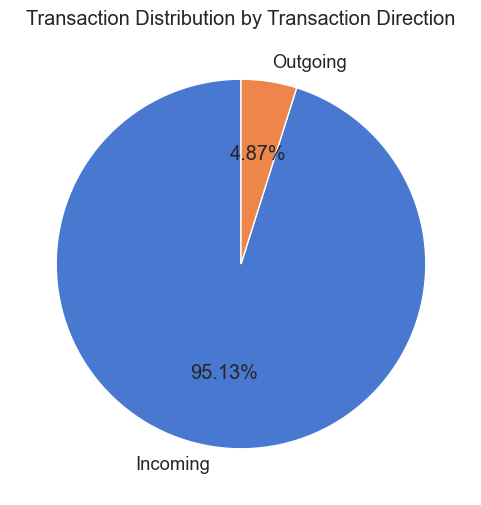

In [44]:
transaction_counts = df_api["trans_direction"].value_counts(normalize=True) * 100

plt.figure(figsize=(6, 6))
transaction_counts.plot(kind="pie", autopct="%.2f%%", startangle=90, labels=transaction_counts.index)
plt.title("Transaction Distribution by Transaction Direction")
plt.ylabel("")
plt.show()

***Although 95.13% of the first transactions were incoming,  
this does not necessarily mean that funding the wallet was the sole reason for its creation.  
This result may indicate various user motivations,  
such as receiving rewards, preparing for future transactions, or personalizing their finances.***  

  


**4. Categorising and Analisis transactions by their type**

In [116]:
function_categories = {
    'transfer': 'Token Transfer',
    'approve': 'Token Approval',
    'mint': 'Token Minting',
    'burn': 'Token Burning',
    'swap': 'Token Swap',
    'execute': 'Contract Execution',
    'bridge': 'Cross-Chain Bridge',
    'init': 'Initialization'
}


def categorize_transaction(function_name):
    if not isinstance(function_name, str):
        return 'Unknown'
    for keyword, category in function_categories.items():
        if keyword in function_name:
            return category
    return 'Unknown'

def categorize_row(row):
    if (row['input'] == '0x' or row['input'] == '0') and row['methodId'] == '0x':
        return 'ETH transfer'
    elif (row['input'] != '0x' and row['methodId'] != '0x'):
        return categorize_transaction(row['functionName'])
    else:
        return 'Unknown'

In [117]:
df_api['transaction_type'] = df_api.apply(categorize_row, axis=1)

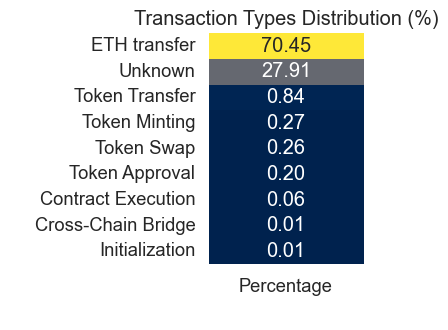

In [118]:
import seaborn as sns

transaction_type_counts = df_api['transaction_type'].value_counts(normalize=True) * 100
transaction_type_counts = transaction_type_counts.sort_values(ascending=False)

transaction_df = pd.DataFrame(transaction_type_counts).reset_index()
transaction_df.columns = ['Transaction Type', 'Percentage']

plt.figure(figsize=(2, 3))
sns.heatmap(transaction_df.set_index('Transaction Type'), annot=True, fmt='.2f', cmap='cividis', cbar=False)
plt.title('Transaction Types Distribution (%)')
plt.xlabel(' ')
plt.ylabel(' ');

***Unknown transactions require additional analysis.  
It is likely that function_categories needs to be expanded to better understand the underlying activities.  
These transactions may include activities not yet categorized or involve complex smart contract interactions.  
Expanding the function_categories could help reduce the 'Unknown' share and provide deeper insights.***

**5. Monthly Distribution of New Wallets**

In [48]:
transactions_per_month = df_api.groupby(df_api.timeStamp.dt.month)['from'].count().reset_index()
transactions_per_month = transactions_per_month.sort_values(by='timeStamp')

In [49]:
transactions_per_month['timeStamp'] = transactions_per_month['timeStamp'].apply(lambda x: calendar.month_abbr[x])

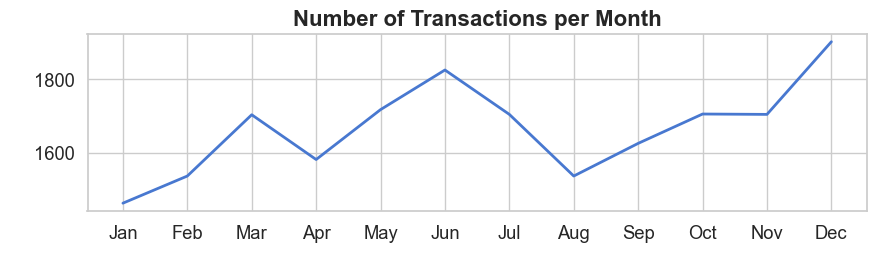

In [50]:
sns.set(style="whitegrid", palette="muted", font_scale=1.2)

plt.figure(figsize=(9, 3))
sns.lineplot(
    data=transactions_per_month,
    x='timeStamp',
    y='from',
    linewidth=2
)

plt.title('Number of Transactions per Month', fontsize=16, fontweight='bold')
plt.xlabel(' ', fontsize=14)
plt.ylabel(' ', fontsize=14)

plt.tight_layout()
plt.show()

***There are certain fluctuations observed, but a deeper analysis, such as comparing data over multiple years,  
is needed to draw conclusions about seasonality.***

**6. Analysis of Transaction Amounts by Category**


    - "Zero": Transactions with 0 (e.g., = 0.0 ETH)
    - "Micro": Transactions with very small amounts (e.g., < 0.001 ETH).
    - "Small": Transactions with small amounts (e.g., 0.001 to 0.1 ETH).
    - "Medium": Transactions with medium amounts (e.g., 0.1 to 1 ETH).
    - "Large": Transactions with large amounts (e.g., 1 to 10 ETH).
    - "Whale": Transactions with very large amounts (e.g., > 10 ETH).

In [51]:
df_api['value'] = df_api['value'].apply(float)
df_api['eth_value'] = df_api['value'] / 1e18

In [52]:
df_api['value_category'] = 'Zero'

bins = [0, 0.001, 0.01, 0.1, 1, 10, float('inf')]
labels = ['Micro', 'Small', 'Medium', 'Large', 'Whale', 'Mega Whale']

df_api.loc[df_api['eth_value'] > 0, 'value_category'] = pd.cut(
    df_api['eth_value'], bins=bins, labels=labels
)

print(df_api['value_category'].value_counts(normalize=True) * 100)

value_category
Medium        41.520
Small         25.895
Large         19.965
Whale          5.525
Micro          3.930
Zero           2.090
Mega Whale     1.075
Name: proportion, dtype: float64


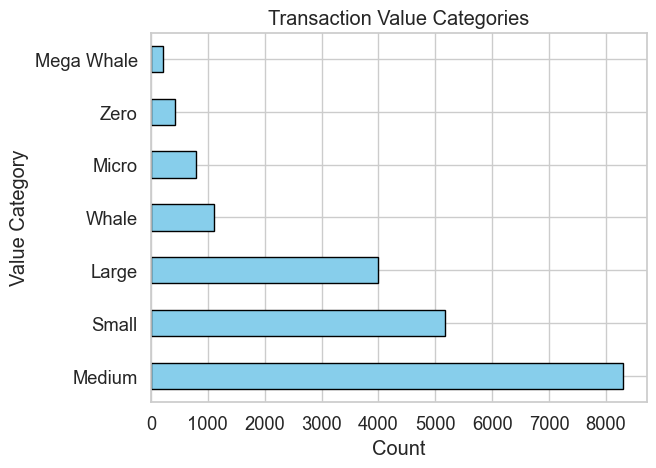

In [53]:
df_api['value_category'].value_counts().plot(kind='barh', color='skyblue', edgecolor='black')
plt.title('Transaction Value Categories')
plt.xlabel('Count')
plt.ylabel('Value Category')
plt.show()


The data shows the following conclusions:

- **Medium-sized transactions (41.52%) make up the largest share, indicating their dominant popularity.**
- **Small transactions (25.895%) are also common, suggesting high activity among smaller users or microtransactions.**
- **Large and Whale transactions together account for 25.49%, highlighting significant economic activity from bigger players.**
- **Micro and Zero transactions represent a smaller portion (around 6%), likely reflecting technical or specialized purposes.**
- **Mega Whale transactions (1.075%) are the rarest, showing their exclusive nature.**

Overall, the distribution of transactions demonstrates a balance between regular users and large players, reflecting a diverse ecosystem.


**7. Analysis of the Difference Between Estimated and Used Gas.**

In [119]:
df_api['gas_difference'] = df_api['gas'] - df_api['gasUsed']

In [120]:
df_api.gas_difference.head(20)

0       65792
1    -3333969
2      189000
3           0
4       29000
5      189000
6           0
7           0
8      186128
9      186128
10   -3989303
11          0
12          0
13   -3201373
14          0
15          0
16     189000
17          0
18     479000
19   -4083601
Name: gas_difference, dtype: int64

*How many transactions in fact used more gas than estimated gas amount:*

In [121]:
negative_gas_df = negative_gas_df = df_api[df_api['gas_difference'] < 0]
negative_gas_df.shape[0]

5369

Is there something in common, like hash or transaction type:

**7.1** Is hash unique?

In [132]:
len(negative_gas_df['hash'].unique())

5369

*The hash are unique, so there are no relatedness with them*

**7.2** Is transaction type unique?

In [133]:
negative_gas_df['transaction_type'].value_counts()

transaction_type
Unknown    5369
Name: count, dtype: int64

*All transactions are Unknown. It means categorize_row function conditions don't work for them.*

**7.3** What is the methodId for transactions? Were they ETH transfers or smart-contracts?

In [131]:
negative_gas_df['methodId'].value_counts()

methodId
1    5366
0       3
Name: count, dtype: int64

In [135]:
len(negative_gas_df['functionName'].unique())

201

In [139]:
negative_gas_df[negative_gas_df['functionName'] == '0x'].shape[0]

5145

*For 99,9% transactions methodId is 1 and 95,88% of functionName is 0x - what means ETH transfers,*  
*and 4,12% of functionName is NOT 0x - what means smart-contracts*

**7.4** Is there any anomalias in gas columns?

In [124]:
negative_gas_df[['gas', 'gasPrice', 'gasUsed']].describe()

,gas,gasPrice,gasUsed
count,5.369000e+03,5.369000e+03,5.369000e+03
mean,7.639242e+04,3.255315e+10,4.142835e+06
std,1.088677e+05,3.135601e+10,1.533797e+06
min,2.100000e+04,0.000000e+00,2.567558e+06
25%,2.100000e+04,1.698127e+10,3.274194e+06
50%,2.100000e+04,2.474069e+10,3.967638e+06
75%,1.000000e+05,3.744887e+10,4.602365e+06
max,2.500000e+06,8.880000e+11,1.676772e+07


***This section analyzed the difference between estimated and actual gas usage.  
It was found that 5,369 transactions used more gas than estimated, with most of them classified as Unknown.  
Additionally, 99.9% of these transactions are ETH transfers, while 4.12% involve smart contracts.  
The gas analysis revealed significant standard deviation, indicating potential anomalies.  
To gain deeper insights, further aspects will be explored in the next sections,  
such as gas distribution across different transaction types and time-based dynamics.***

**8. Distribution across Different Transaction Types**

**8.1** Gas Used Distribution for All Transactions

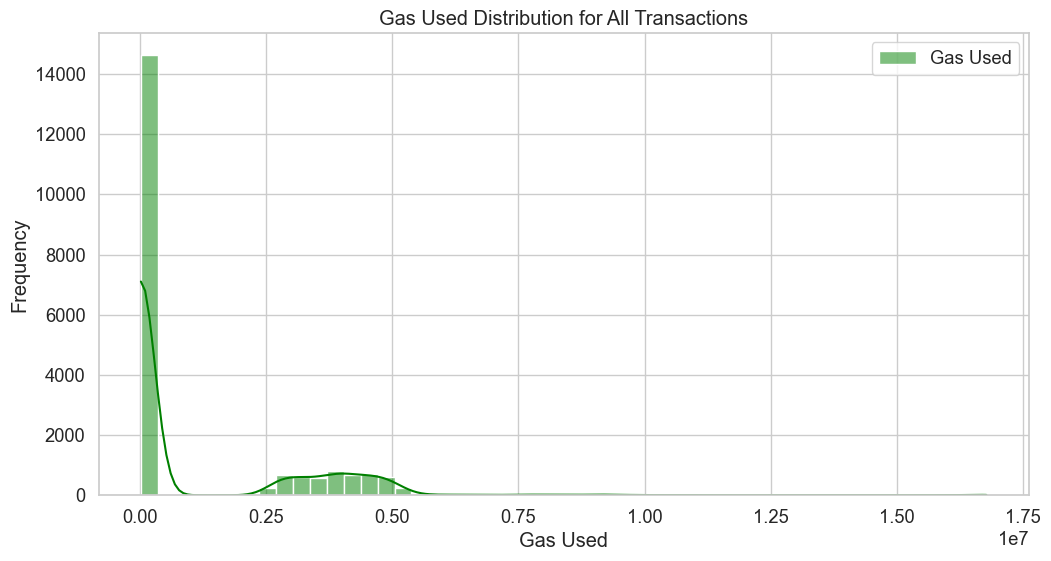

In [142]:
plt.figure(figsize=(12, 6))
sns.histplot(df_api['gasUsed'], bins=50, kde=True, color='green', label='Gas Used')
plt.xlabel('Gas Used')
plt.ylabel('Frequency')
plt.title('Gas Used Distribution for All Transactions')
plt.legend()
plt.show()

***- Most transactions consume very little gas (close to 0), which is expected for simple ETH transfers.*** 

***- There is a long tail indicating fewer transactions with significantly higher gas consumption, likely related to complex smart contracts.***

**8.2** Gas Used Distribution for Transactions with Negative Gas Difference

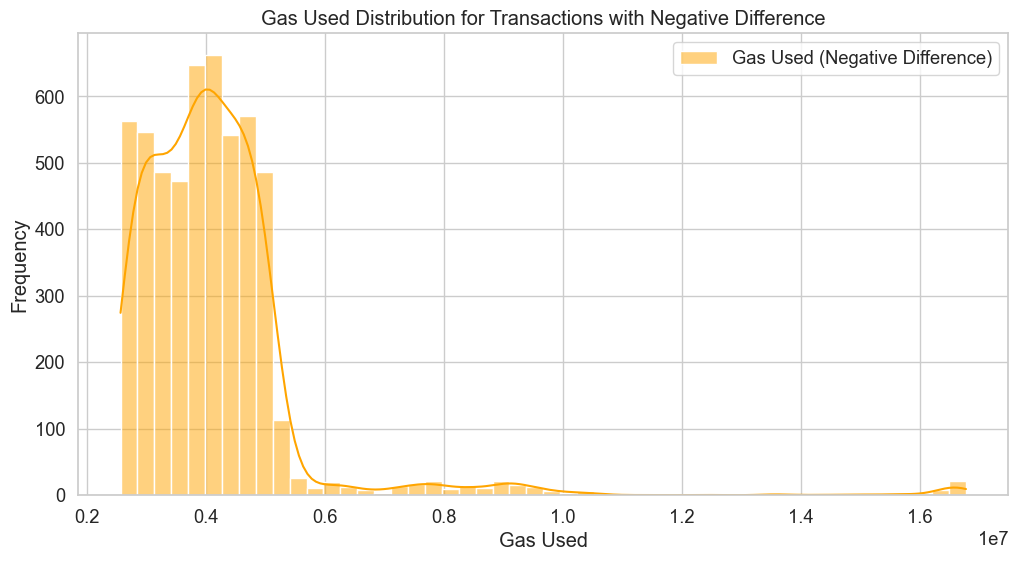

In [143]:
plt.figure(figsize=(12, 6))
sns.histplot(negative_gas_df['gasUsed'], bins=50, kde=True, color='orange', label='Gas Used (Negative Difference)')
plt.xlabel('Gas Used')
plt.ylabel('Frequency')
plt.title('Gas Used Distribution for Transactions with Negative Difference')
plt.legend()
plt.show()

***- The majority of these transactions consume a medium amount of gas (0.4–0.5 million), suggesting a systematic characteristic or category of these transactions.***  

***- There are almost no simple operations with low gas usage, which is unusual for ETH transfers.***  

***- The long tail shows some complex transactions, but they are less common compared to the overall dataset.***



*Despite 95% of anomalous transactions being labeled as 0x (ETH transfers), their gas usage is far higher than the standard 21,000 for simple transfers.  
This may indicate additional actions, such as proxy contracts, internal transactions, or network anomalies.*